# DCGAN - PyTorch using CIFAR10

### 작성자: 고려대학교 수학과 석사과정 최선묵

[References]  
- [Goodfellow's GAN Paper Link](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf)  
- [DCGAN Paper Link](https://arxiv.org/pdf/1511.06434.pdf)
- [DCGAN PyTorch Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import ConcatDataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torchvision.utils as vutils

from torchsummary import summary

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Preparation

In [5]:
transform=transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                               ])

trainset = CIFAR10(root='./', train=True, download=True, transform=transform)
testset = CIFAR10(root='./', train=False, download=True, transform=transform)

BATCH_SIZE = 128

dataset = ConcatDataset([trainset, testset])

trainloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Deep Convolutional GANs

### Architecture guidelines for stable Deep Convolutional GANs

- Replace any pooling layers with `strided convolutions` (discriminator) and `fractional-strided convolutions` (generator).
- Use `BatchNormaliziation` in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use `ReLU` activation in `generator` for all layers except for the output, which uses Tanh.
- Use `LeakyReLU` activation in the `discriminator` for all layers.

In [6]:
## Hyperparameters
latent_dim = 100

EPOCHS = 80
LR = 2e-4
BETA1=0.5 # Beta1 for Adam optimizers

### Weight Initialization

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

### Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, noise_dim:int):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=noise_dim, out_channels=256, 
                               kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
                         
            nn.ConvTranspose2d(in_channels=256, out_channels=128, 
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
                          
            nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
                             
            nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
        
            nn.Conv2d(in_channels=32, out_channels=3, 
                      kernel_size=3, stride=1, padding=1, bias=True),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
g_model = Generator(noise_dim=latent_dim).to(device)
g_model.apply(weights_init)
summary(g_model, input_size=(latent_dim, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7           [-1, 64, 16, 16]         131,072
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10           [-1, 32, 32, 32]          32,768
      BatchNorm2d-11           [-1, 32, 32, 32]              64
             ReLU-12           [-1, 32, 32, 32]               0
           Conv2d-13            [-1, 3, 32, 32]             867
             Tanh-14            [-1, 3,

### Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_enc = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=128, out_channels=256, 
                      kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=256, out_features=64, bias=False),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features=64, out_features=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, input):
        x = self.conv_enc(input)
        x = self.avgpool(x)
        x = x.view(x.size(0), x.size(1))
        x = self.classifier(x)

        return x

In [12]:
d_model = Discriminator().to(device)
d_model.apply(weights_init)
summary(d_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
         LeakyReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,432
       BatchNorm2d-5             [-1, 64, 8, 8]             128
         LeakyReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]          73,728
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]         294,912
      BatchNorm2d-11            [-1, 256, 2, 2]             512
        LeakyReLU-12            [-1, 256, 2, 2]               0
AdaptiveAvgPool2d-13            [-1, 256, 1, 1]               0
           Linear-14                   

### GAN model

In [13]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

In [14]:
# Training Loop
def trainGAN(num_epochs, dataloader, generator, discriminator, g_optimizer, d_optimizer, d_iter=1):
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    print("Starting Training Loop...")
    
    for epoch in range(num_epochs):
        
        for i, data in enumerate(dataloader, 0):
            real_img = data[0]
            batch_size = real_img.size(0)
            
            # Train Discriminator d_iter times with fixed Generator.
            for _ in range(d_iter):    
                discriminator.zero_grad()

                # Train disicriminator using real batch images. Real images have labels 1.
                real_img = real_img.to(device)
                real_label = torch.full((batch_size,), 1., dtype=torch.float, device=device)
                d_real_output = discriminator(real_img).view(-1) # size = (batch_size, 1) -> (batch_size)
                d_loss_real = criterion(d_real_output, real_label)
                d_loss_real.backward() # Compute gradients

                # Train disicriminator using fake batch images. Fake images have labels 0.
                noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
                fake_img = generator(noise)
                fake_label = torch.full((batch_size,), 0., dtype=torch.float, device=device)
                d_fake_output = discriminator(fake_img.detach()).view(-1)
                d_loss_fake = criterion(d_fake_output, fake_label)
                d_loss_fake.backward() # Compute gradients
                
                # Optimize
                d_optimizer.step()

                d_loss = d_loss_real + d_loss_fake
                D_x = d_real_output.mean().item()
                D_G_z1 = d_fake_output.mean().item()
            
            # Train Generator with fixed discriminator.
            generator.zero_grad()

            # Train generator using fake batch images. Fake images have labels 1 for generators.
            d_fake_output = discriminator(fake_img).view(-1) # size = (batch_size, 1) -> (batch_size)
            g_loss = criterion(d_fake_output, real_label)
            g_loss.backward() # Compute gradients
            g_optimizer.step() # Optimize
            
            D_G_z2 = d_fake_output.mean().item()
            
            # Output training stats
            if i % 100 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        d_loss.item(), g_loss.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())
            
            iters += 1 
        # Check how the generator is doing by saving G's output on fixed_noise
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    return img_list, G_losses, D_losses

In [15]:
d_optimizer = optim.Adam(d_model.parameters(), lr=LR, betas=(BETA1, 0.999))
g_optimizer = optim.Adam(g_model.parameters(), lr=LR, betas=(BETA1, 0.999))

img_list, G_losses, D_losses = trainGAN(EPOCHS, trainloader, g_model, d_model, g_optimizer, d_optimizer, d_iter=1)

Starting Training Loop...
[0/80][0/469]	Loss_D: 1.4176	Loss_G: 0.7235	D(x): 0.5014	D(G(z)): 0.5029 / 0.4888
[0/80][100/469]	Loss_D: 1.2176	Loss_G: 0.8382	D(x): 0.5375	D(G(z)): 0.4434 / 0.4349
[0/80][200/469]	Loss_D: 1.0658	Loss_G: 0.9251	D(x): 0.5835	D(G(z)): 0.4059 / 0.3982
[0/80][300/469]	Loss_D: 0.9436	Loss_G: 1.0137	D(x): 0.6305	D(G(z)): 0.3772 / 0.3663
[0/80][400/469]	Loss_D: 1.0575	Loss_G: 1.1019	D(x): 0.5540	D(G(z)): 0.3493 / 0.3375
[1/80][0/469]	Loss_D: 0.8083	Loss_G: 1.1987	D(x): 0.6631	D(G(z)): 0.3222 / 0.3065
[1/80][100/469]	Loss_D: 0.6393	Loss_G: 1.3106	D(x): 0.7469	D(G(z)): 0.2896 / 0.2750
[1/80][200/469]	Loss_D: 0.6349	Loss_G: 1.5007	D(x): 0.7110	D(G(z)): 0.2440 / 0.2313
[1/80][300/469]	Loss_D: 0.5012	Loss_G: 1.5679	D(x): 0.7851	D(G(z)): 0.2255 / 0.2141
[1/80][400/469]	Loss_D: 0.4273	Loss_G: 1.6399	D(x): 0.8266	D(G(z)): 0.2088 / 0.1979
[2/80][0/469]	Loss_D: 0.3635	Loss_G: 1.8354	D(x): 0.8432	D(G(z)): 0.1731 / 0.1651
[2/80][100/469]	Loss_D: 0.3756	Loss_G: 1.8773	D(x): 0.82

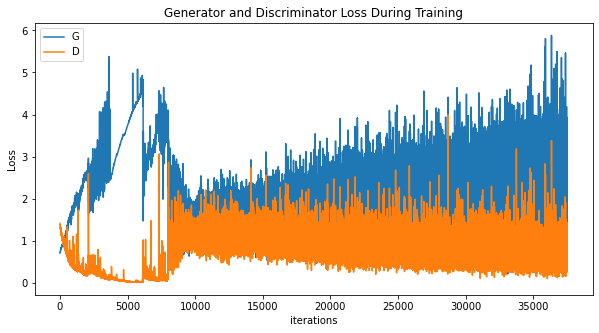

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('torch_train_loss_plot.png')
plt.show()

### Save & Load models

In [ ]:
# Save trained models

torch.save(g_model.state_dict(), 'torch_generator.model')
torch.save(d_model.state_dict(), 'torch_discriminator.model')



# from google.colab import files

# files.download('torch_generator.model')
# files.download('torch_discriminator.model')

In [20]:
# Load trained models
def load_parameters(model, path):
    model_state = model.state_dict()
    loaded_state = torch.load(path)
    for name, param in loaded_state.items():
        origname = name
        if name not in model_state:
            name = name.replace("module.", "")
            if name not in model_state:
                print("%s is not in the model."%origname)
                continue
        if model_state[name].size() != loaded_state[origname].size():
            print("Wrong parameter length: %s, model: %s, loaded: %s"%(origname, model_state[name].size(), loaded_state[origname].size()))
            continue
        model_state[name].copy_(param)

In [21]:
g_model_2 = Generator(noise_dim=latent_dim)
d_model_2 = Discriminator()

load_parameters(g_model_2, './torch_generator.model')
load_parameters(d_model_2, './torch_discriminator.model')

## Test

(10, 32, 32, 3)


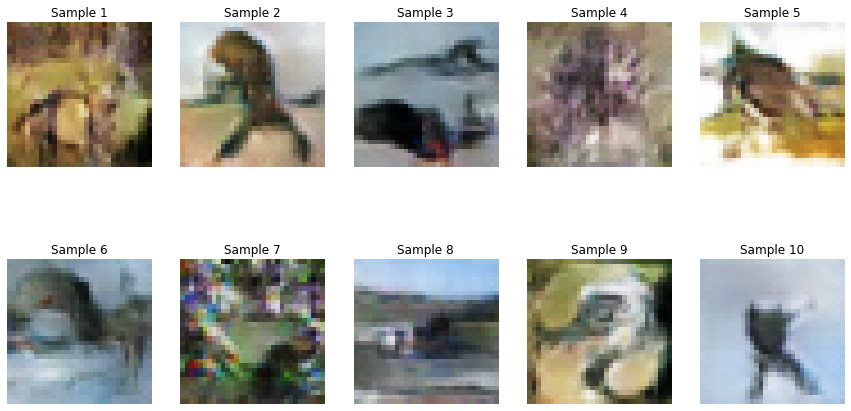

In [22]:
noise = torch.randn(10, latent_dim, 1, 1, device=device)
g_model_2.to(device)
g_model_2.eval()

generated_images = g_model_2(noise).detach().cpu().numpy()
generated_images = np.transpose(generated_images, (0,2,3,1))
generated_images = (generated_images+1)/2 # convert the values from [-1,1] to [0,1] for plots
print(generated_images.shape)

plt.rcParams['figure.figsize'] = (15.0, 8.0)

rows = 2
columns = 5

for i in range(10) : 
    image_index = i+1      # image index 
    title = "Sample {}".format(image_index) # image title
    plt.subplot(rows, columns, image_index) # subplot 
    plt.title(title)   # title 
    plt.axis('off')
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.imshow(generated_images[i])  
plt.show()